In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import shap
from sklearn.model_selection import train_test_split
from windowshap import SlidingWindowSHAP, StationaryWindowSHAP, DynamicWindowSHAP
import timeit
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
shap.initjs()

2023-08-03 09:12:08.038067: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 09:12:08.127073: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 09:12:10.840583: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Synthetic data

This function generates a synthetic time series in which each feature sequence is generated using the sin() or cos() function. However, an anomaly interval is inserted at random into one of the feature sequences. If the feature with the anomaly is the first feature, the sample label is 1; otherwise, it is 0.

In [2]:
def synthetic_data(n_samples=100, n_steps=10, n_features=4):
    # Creating input data
    # 噪声强度
    lam = 0.2
    # 异常数据强度
    anomaly_lam = 10
    # 正态分布随机数生成器
    eps = np.random.normal
    x=np.zeros((n_samples, n_steps, n_features))
    labels = np.zeros(n_samples)
    # 首先对每个样本i进行处理
    for i in range(n_samples):
        # 特征起始时间
        t0 = np.random.randint(1, 5, size=n_features)
        # 特征频率
        w = np.random.randint(1, 5, size=n_features)
        # 时间序列
        t = np.arange(n_steps)
        # 对样本对应的特征进行处理：对于每个特征j，根据j的奇偶性生成对应的正弦或余弦信号，并添加噪声（正态分布生成）；
        for j in range(n_features):
            if j%2 == 0:
                x[i,:,j] = np.sin((t-t0[j])/w[j])
            else:
                x[i,:,j] = np.cos((t-t0[j])/w[j])
            x[i,:,j] = x[i,:,j] + lam*eps(size=n_steps)

        # adding anomaly
#         anom_dur = np.random.randint(n_steps/10, n_steps/2)
        # 随机生成异常的持续时间，并将异常数据加到数据序列x中的相应位置
        anom_dur = 20
        anom_start = np.random.randint(0, n_steps - anom_dur)
        anom_end = anom_start + anom_dur
        # 创建样本标签，若anom_j==0，则标签为1，表示该样本包含异常，否则标签为0
        anom_j = np.random.randint(0, n_features)
        x[i, anom_start:anom_end, anom_j] += anomaly_lam*eps(size=anom_dur)

        # Creating the label
        labels[i] = 1 if anom_j==0 else 0
    return x, labels

Data seperation to test and train

In [3]:
x, label = synthetic_data(n_samples=10000, n_steps=120, n_features=4) ## 数据维度，(10000, 120, 4) (10000,)
train_x, test_x, train_y, test_y = train_test_split(x, label, test_size=0.3, random_state=0,
                                                    stratify=label)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0,
                                                 stratify=train_y)

# Prediction Model

In [4]:
# from tensorflow.python.keras.layers import Input, Dense, Dropout, LSTM, GRU#, TimeDistributed Bidirectional
from keras.layers import Dense, Dropout, LSTM, BatchNormalization, GRU
from tensorflow.python.keras.callbacks import EarlyStopping
# from tensorflow.python.keras import Model, Sequential
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers

num_hidden = [70, 20]
num_neurons = 200
es_patience = 20
epochs = 40
num_output = 1
batch_size = 32
drop_rate = 0.3
reg_rate = 0.004

K.clear_session()
model = Sequential()
input_shape = (x.shape[1], x.shape[2])
model.add(GRU(units=num_neurons, activation='relu', input_shape=input_shape,
              recurrent_dropout=0.1, dropout=0.1))
for i in num_hidden:
    model.add(Dropout(drop_rate))
    model.add(Dense(units=i, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)))
model.add(Dense(units=num_output, activation='sigmoid'))

# Creating and compiling model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=es_patience)

# Class weights
class_weights = {0:len(train_y)/(train_y==0).sum(),
                 1:len(train_y)/(train_y==1).sum()}

model.compile(optimizer=SGD(learning_rate=0.01, clipvalue=0.5), loss='binary_crossentropy',
              metrics=['accuracy'])
# model.build(input_shape)
model.summary()
train_history = model.fit(train_x, train_y, batch_size=batch_size,
                          epochs=epochs, verbose=2,
                          validation_data=(val_x, val_y),
                          class_weight=class_weights,
                          callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 200)               123600    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 70)                14070     
                                                                 
 dropout_1 (Dropout)         (None, 70)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                1420      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 139111 (543.40 KB)
Trainable params: 13911

In [5]:
from sklearn.metrics import roc_auc_score, accuracy_score
print(roc_auc_score(test_y, model.predict(test_x)))
print(accuracy_score(test_y, np.round(model.predict(test_x))))

94/94 [==============================] - 21s 188ms/step
1.0
94/94 [==============================] - 11s 122ms/step
1.0


In [6]:
test_y[20:30]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## SHAP interpretation

In [7]:
num_background = 50
num_test = 28
background_data, test_data = train_x[:num_background], test_x[num_test:num_test+2]

## 1- Stationary WindowSHAP

In [8]:
tic = timeit.default_timer()
ts_phi_1 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    window_len = 20
    gtw = StationaryWindowSHAP(model, window_len, B_ts=background_data, test_ts=test_data[i:i+1], model_type='lstm')
    ts_phi_1[i,:,:] = gtw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

2/2 [==============================] - 0s 101ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

3275/3275 [==============================] - 330s 101ms/step


100%|██████████| 1/1 [16:23<00:00, 983.10s/it]


2/2 [==============================] - 0s 72ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

3275/3275 [==============================] - 330s 101ms/step


100%|██████████| 1/1 [15:49<00:00, 949.25s/it]

Total time: 1933.5570801950525


## 2- Sliding WindowSHAP

In [9]:
tic = timeit.default_timer()
ts_phi_2 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    window_len = 20
    stride = 10
    gtw = SlidingWindowSHAP(model, stride, window_len, background_data, test_data[i:i+1], model_type='lstm')
    ts_phi_2[i,:,:] = gtw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

2/2 [==============================] - 0s 81ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 6s 94ms/step


100%|██████████| 1/1 [00:07<00:00,  7.88s/it]


2/2 [==============================] - 0s 84ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 9s 138ms/step


100%|██████████| 1/1 [00:13<00:00, 13.42s/it]


2/2 [==============================] - 0s 155ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 16s 239ms/step


100%|██████████| 1/1 [00:18<00:00, 18.66s/it]


2/2 [==============================] - 0s 180ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 13s 204ms/step


100%|██████████| 1/1 [00:16<00:00, 16.60s/it]


2/2 [==============================] - 0s 174ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 20s 308ms/step


100%|██████████| 1/1 [00:22<00:00, 22.67s/it]


2/2 [==============================] - 1s 274ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 6s 90ms/step


100%|██████████| 1/1 [00:07<00:00,  7.86s/it]


2/2 [==============================] - 0s 67ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 15s 237ms/step


100%|██████████| 1/1 [00:19<00:00, 19.56s/it]


2/2 [==============================] - 0s 97ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 15s 228ms/step


100%|██████████| 1/1 [00:17<00:00, 17.77s/it]


2/2 [==============================] - 0s 137ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 19s 304ms/step


100%|██████████| 1/1 [00:22<00:00, 22.56s/it]


2/2 [==============================] - 1s 311ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 6s 89ms/step


100%|██████████| 1/1 [00:07<00:00,  7.75s/it]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 71ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 23s 366ms/step


100%|██████████| 1/1 [00:26<00:00, 26.17s/it]


2/2 [==============================] - 1s 195ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 14s 208ms/step


100%|██████████| 1/1 [00:16<00:00, 16.67s/it]


2/2 [==============================] - 0s 103ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 11s 175ms/step


100%|██████████| 1/1 [00:14<00:00, 14.67s/it]


2/2 [==============================] - 0s 99ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 9s 144ms/step


100%|██████████| 1/1 [00:12<00:00, 12.79s/it]


2/2 [==============================] - 0s 96ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 14s 218ms/step


100%|██████████| 1/1 [00:17<00:00, 17.69s/it]


2/2 [==============================] - 0s 115ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 15s 231ms/step


100%|██████████| 1/1 [00:18<00:00, 18.01s/it]


2/2 [==============================] - 0s 90ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 10s 165ms/step


100%|██████████| 1/1 [00:15<00:00, 15.10s/it]


2/2 [==============================] - 0s 194ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 11s 168ms/step


100%|██████████| 1/1 [00:15<00:00, 15.24s/it]


2/2 [==============================] - 0s 110ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 20s 314ms/step


100%|██████████| 1/1 [00:21<00:00, 21.83s/it]


2/2 [==============================] - 0s 103ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 16s 243ms/step


100%|██████████| 1/1 [00:18<00:00, 18.74s/it]


2/2 [==============================] - 0s 136ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 20s 312ms/step


100%|██████████| 1/1 [00:23<00:00, 23.39s/it]


2/2 [==============================] - 0s 172ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 14s 211ms/step


100%|██████████| 1/1 [00:17<00:00, 17.41s/it]

Total time: 382.6569806539919


## 3- Dynamic WindowSHAP

In [10]:
tic = timeit.default_timer()
ts_phi_3 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    delta = 0.3
    n_w = 8
    btw = DynamicWindowSHAP(model, delta, n_w, background_data, test_data[i:i+1], model_type='lstm')
    ts_phi_3[i,:,:] = btw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

2/2 [==============================] - 0s 64ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

13/13 [==============================] - 1s 103ms/step


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


2/2 [==============================] - 0s 74ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 2s 94ms/step


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


2/2 [==============================] - 0s 86ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

47/47 [==============================] - 10s 214ms/step


100%|██████████| 1/1 [00:11<00:00, 11.54s/it]


2/2 [==============================] - 0s 126ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

13/13 [==============================] - 2s 110ms/step


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


2/2 [==============================] - 0s 103ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 2s 109ms/step


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


2/2 [==============================] - 0s 70ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

47/47 [==============================] - 5s 108ms/step


100%|██████████| 1/1 [00:08<00:00,  8.27s/it]

Total time: 31.148458702955395


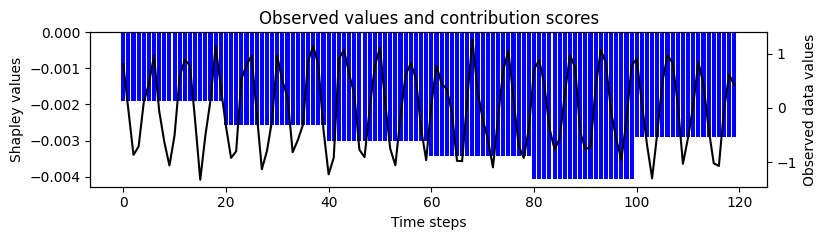

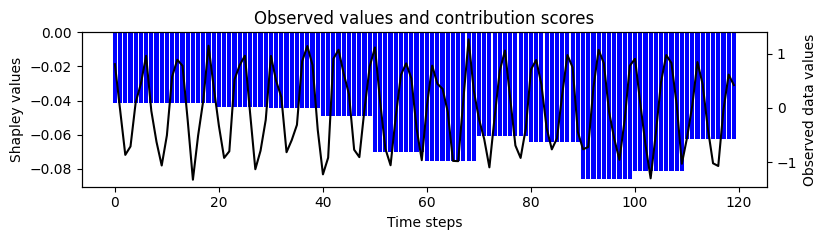

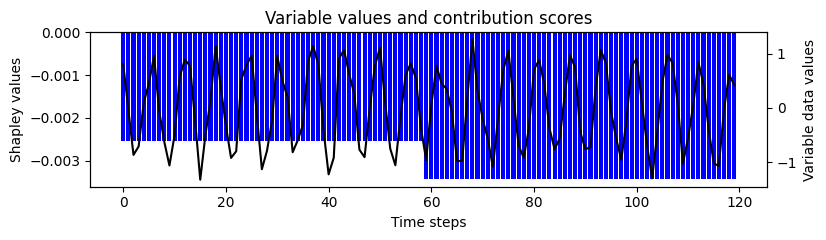

In [12]:
from util import heat_map
var = 0
phi_index = 0 
heat_map(start=0, stop=120, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_1[phi_index, :, var], var_name='Observed', plot_type='bar')
heat_map(start=0, stop=120, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_2[phi_index, :, var], var_name='Observed', plot_type='bar')
heat_map(start=0, stop=120, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_3[phi_index, :, var], var_name='Variable', plot_type='bar')